In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import requests
from io import StringIO
import yfinance as yf
import random
import math

In [2]:
# Numerical Solution to Black-Scholes Equation

dctHolder = {}
zArray = np.linspace(0,1,100)

for z in zArray:
    dctHolder[z] = np.zeros(100)

cFrame = pd.DataFrame(dctHolder,zArray) # build place holder for call option

# Now define some useful functions (for checking the solution and other things)

def xp(S,K,r,sigma,T,t):
    return (np.log(S/K)+(r+sigma**2/2)*(T-t))/(sigma*(np.sqrt(T-t)))

def xm(S,K,r,sigma,T,t):
    return (np.log(S/K)+(r-sigma**2/2)*(T-t))/(sigma*(np.sqrt(T-t)))

def D(z):
    return sp.stats.norm.cdf(z, loc=0, scale=1) # Redefine the name to minimize typing

def f(S,K):
    return np.max([S-K,0])

# If we take the expiry time as T = 1 in the above dataframe, then we can fix a K and and fix the value C(S,t=T) at f(S,K). This plus the fact that C(0,t) = 0 and C(S -> \infty, t) -> \infty suggests that we can impose an insulating boundary condition at the far end (although there are other choices). 

# By the way, we've chosen our keys so that they are essentiall dimensionless. This means we should be specifying strike price as a fraction of the price of the underlying.

K = 1/2
tEndArray = zArray - K
tBoundary = []
for s in tEndArray:
    t = f(s,0)
    tBoundary.append(t)

cFrame.iloc[-1,:] = tBoundary

r = 1.1
sigma = 1
dt = 0.01

interiorArray = zArray[1:99]/0.01
rArray = r*np.ones(len(interiorArray))

for k in range(99,0,-1):
    A = np.ones(len(interiorArray)) - (rArray + interiorArray + interiorArray**2*sigma**2)*dt
    B = (interiorArray + interiorArray**2*sigma**2/2)*dt
    C = dt*interiorArray**2*sigma**2/2

    cFrame.iloc[k-1,1:99] = A*cFrame.iloc[k,1:99].to_numpy() + B*cFrame.iloc[k,2:100].to_numpy() + C*cFrame.iloc[k,0:98].to_numpy()
    cFrame.iloc[k-1,99] = cFrame.iloc[k-1,98] # Insulating boundary condition at end

# This simple method is correct, but it doesn't satisfy the stability conditions for small enough dt. For this, stable dt ~ 10^-8, which is SIX orders of magnitude smaller than what we use here, so we need to employ a more stable method. See the plot below for how it blows up


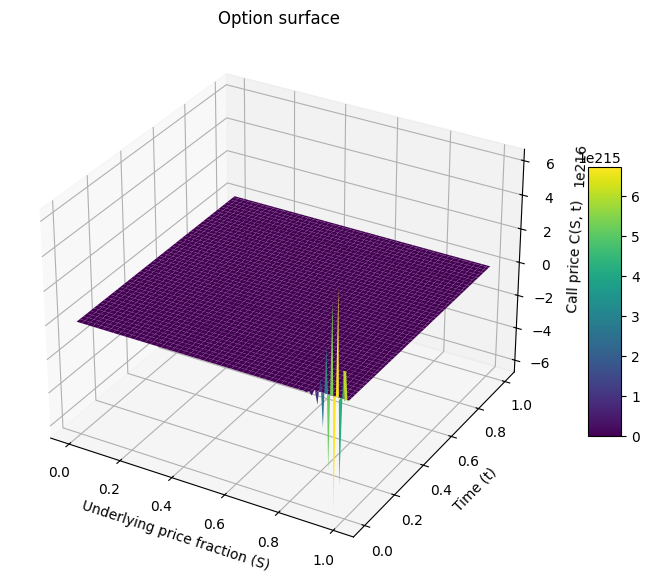

In [3]:
# Plot our solution here

from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
from matplotlib import cm

# Extract grid axes and values
X, Y = np.meshgrid(cFrame.columns, cFrame.index)  # grid of S (x) and t (y)
Z = cFrame.values  # call prices

# Create figure
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, edgecolor='none')

# Labels and title
ax.set_xlabel('Underlying price fraction (S)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Call price C(S, t)')
ax.set_title('Option surface')

# Add colorbar
fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

In [4]:
# Apply Crank-Nicolson

# Initialize parameters
r = 0.05 # interest rate
sigma = 0.001 # SD
t0 = 0 # initial time
t1 = 1 # final time
s0 = 0 # initial underlying price
s1 = 5 # final underlying price
n = 250 # number of grid points
k = 1 # strike price
dS = (s1-s0)/(n-1) # underlying step size 
dt = (t1-t0)/(n-1) # time step size

# S, t arrays
sArray = np.linspace(s0,s1,n)
tArray = np.linspace(t0,t1,n)

# Build dataframe place holder
dctHolder = {}
zArray = np.linspace(0,1,100)

for j in range(len(sArray)):
    dctHolder[sArray[j]] = np.zeros(len(sArray))

cFrame = pd.DataFrame(dctHolder,tArray) # build place holder for call option

# Set boundary for option
tBoundary = []
for s in sArray:
    cEnd = np.max([s-k,0])
    tBoundary.append(cEnd)

cFrame.iloc[-1,:] = tBoundary

# Assuming assymptotic boundary
cMaxArray = []

for t in tArray:
    cMax = s1 - k*np.exp(-r*(t1-t))
    cMaxArray.append(cMax)

cFrame.iloc[:,-1] = cMaxArray

# Define thomas algorithm function
def thomas(a,b,c,d):
    xArray = np.zeros(len(d))
    
    for i in range(len(a)):
        r = a[i]/b[i]
        b[i+1] = b[i+1] - r*c[i]
        d[i+1] = d[i+1] - r*d[i]

    for i in range(len(xArray)-1,-1,-1):
        if i == len(xArray)-1:
            xArray[i] = d[i]/b[i]
        else:
            xArray[i] = (d[i]-c[i]*xArray[i+1])/b[i]

    return xArray

bArray = r*np.ones(len(sArray)) + (sigma**2/dS**2)*sArray**2
cArray = -((r/(2*dS))*sArray + (sigma**2/(2*dS**2))*sArray**2)
aArray = (r/(2*dS))*sArray - (sigma**2/(2*dS**2))*sArray**2 

# Get the interior of these - Justified by taking interior on sArray as column index in df
bArray = bArray[1:len(bArray)-1]
aArray = aArray[1:len(aArray)-1]
cArray = cArray[1:len(cArray)-1]

# Loop for CN method for eqn
for j in range(len(tArray)-1,0,-1):
    cFrameMiddleArray = cFrame.iloc[j,1:n-1].to_numpy()
    cFrameLeftArray = cFrame.iloc[j,0:n-2].to_numpy()
    cFrameRightArray = cFrame.iloc[j,2:n].to_numpy()
    d = (2+bArray*dt)*cFrameMiddleArray + dt*aArray*cFrameLeftArray + dt*cArray*cFrameRightArray
    a = -aArray[0:len(aArray)-1]*dt
    b = (2-bArray*dt)
    c = -cArray[1:len(cArray)]*dt
    x = thomas(a,b,c,d)
    cFrame.iloc[j-1,1:n-1] = x

# Solving this directly actually is VERY unstable even for CN; we can only solve this for reasonably small volatility due to stability considerations. I think the ideal case is to solve the usual simple heat equation then invert the associated coordinate transform in order to get reasonable values. See the plot below; everything looks good except for the divergence near t = 0 and S near S_max. See Seydel's "Tools for Computational Finance" for more details. Chapter 4 covers this issue extensively.

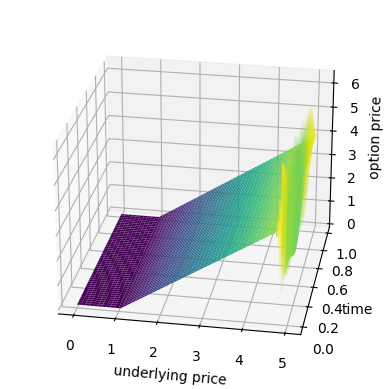

In [5]:
# Rip and paste the plotting stuff from the internet =)

# Create meshgrid from index and columns
x, y = np.meshgrid(cFrame.columns.astype(float), cFrame.index.astype(float))
z = cFrame.values

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# Rotate the view 10 degrees counterclockwise around z-axis
ax.view_init(elev=25, azim=-80)  # adjust elev for tilt, azim for rotation

# Label axes
ax.set_xlabel('underlying price')
ax.set_ylabel('time')
ax.set_zlabel('option price')

plt.show()

In [6]:
# Build analytical solution for BS equation and give 3D plot. For comparing. 

# Initialize parameters
r = 0.05 # interest rate
sigma = 0.001 # volatility
t0 = 0 # initial time
t1 = 1 # final time
s0 = 0 # initial underlying price
s1 = 5 # final underlying price
n = 250 # number of grid points
k = 1 # strike price
dS = (s1-s0)/(n-1) # underlying step size 
dt = (t1-t0)/(n-1) # time step size

# S, t arrays
sArray = np.linspace(s0,s1,n)
tArray = np.linspace(t0,t1,n)

cSolnDct = {}

# Define some useful functions

def xp(S,K,r,sigma,T,t):
    return (np.log(S/K)+(r+sigma**2/2)*(T-t))/(sigma*(np.sqrt(T-t)))

def xm(S,K,r,sigma,T,t):
    return (np.log(S/K)+(r-sigma**2/2)*(T-t))/(sigma*(np.sqrt(T-t)))

def D(z):
    return sp.stats.norm.cdf(z, loc=0, scale=1) # Redefine the name to minimize typing

tv, sv = np.meshgrid(tArray,sArray,indexing='ij')

for j in range(len(sArray)):
    cArraySj = []
    for i in range(len(tArray)):
        if sv[i,j]==0:
            xplus = -np.inf
            xminus = -np.inf
        elif tv[i,j]==t1:
            xplus = np.inf
            xminus = np.inf
        else:
            xplus = xp(sv[i,j],k,r,sigma,t1,tv[i,j])
            xminus = xm(sv[i,j],k,r,sigma,t1,tv[i,j])
        u = sv[i,j]*D(xplus) - k*np.exp(-r*(t1-tv[i,j]))*D(xminus)
        cArraySj.append(u)
    cSolnDct[sArray[j]] = cArraySj

cFrameAnalytic = pd.DataFrame(cSolnDct,tArray)

# Agreement with numerical solution is VERY strong in the stable region. Near the stiff part of the system, we would need to rely on higher order or adaptive methods, but this is enough to demonstrate compatibility. Good! (Besides inspection, we could just take the difference and absolute value of this to see where the discrepancy starts, but inspection by eye is pretty good for this case.)

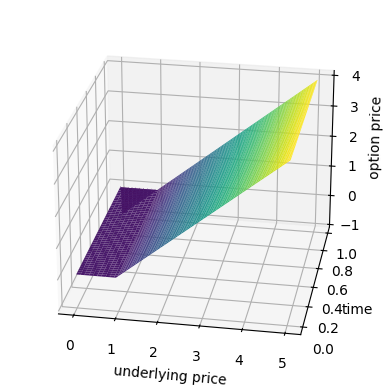

In [7]:
# Rip and paste the plotting stuff from the internet =)

# Create meshgrid from index and columns
x, y = np.meshgrid(cFrameAnalytic.columns.astype(float), cFrameAnalytic.index.astype(float))
z = cFrameAnalytic.values

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# Rotate the view 10 degrees counterclockwise around z-axis
ax.view_init(elev=25, azim=-80)  # adjust elev for tilt, azim for rotation

# Label axes
ax.set_xlabel('underlying price')
ax.set_ylabel('time')
ax.set_zlabel('option price')

plt.show()